In [31]:
import logging
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (
        train_test_split,
        cross_validate,
        cross_val_predict,
        GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    PowerTransformer,
    LabelEncoder,
    MinMaxScaler
)
from sklearn.tree import (
    DecisionTreeClassifier,
    plot_tree
)
from sklearn.ensemble import(
    GradientBoostingClassifier
)
from sklearn.ensemble import(
    RandomForestClassifier
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import(
    accuracy_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    DetCurveDisplay,
    matthews_corrcoef
)
from sklearn.inspection import permutation_importance
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

### **1. Data loading**
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [3]:
df_raw = pd.read_csv('../data/Maternal Health Risk Data Set.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [4]:
df_raw.sample(10, random_state=2025)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
109,32,140,100,7.9,98.0,78,high risk
185,55,100,65,6.1,98.0,66,low risk
402,35,100,70,7.8,98.0,60,low risk
800,32,120,80,6.8,98.0,70,mid risk
684,32,140,100,6.9,98.0,78,high risk
555,50,130,100,16.0,98.0,75,mid risk
34,21,75,50,6.1,98.0,70,low risk
689,40,160,100,19.0,98.0,77,high risk
172,20,100,90,7.1,98.0,88,low risk
528,15,78,49,7.5,98.0,77,low risk


Observamos un dataset bastante completo, no hay informacion nula, todas las variables son númericas, tenemos la variable objetivo con 3 categorias. 
En la siguiente tabla vemos el diccionario de las variables

#### **Data Dictionary**
|Name|Description|Type|Units|
|----|-----------|----|-----|
|Age|Any ages in years when a women during pregnant.|Int|None|
|SystolicBP|Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.|Int|None|
|DiastolicBP|Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.|Int|None|
|BS|Blood glucose levels is in terms of a molar concentration|float|nmol/L|
|BodyTemp| |float|F|
|HeartRate|A normal resting heart rate|Int|bpm|
|RiskLevel|Predicted Risk Intensity Level during pregnancy considering the previous attribute.|Cat|None|

2. Data preprocessing
Objectives: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [5]:
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.lower()
df_baking['risklevel'] = df_baking['risklevel'].astype('category')
df_baking = df_baking.drop_duplicates() # elimine filas duplicadas en el dataset
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 452 entries, 0 to 705
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          452 non-null    int64   
 1   systolicbp   452 non-null    int64   
 2   diastolicbp  452 non-null    int64   
 3   bs           452 non-null    float64 
 4   bodytemp     452 non-null    float64 
 5   heartrate    452 non-null    int64   
 6   risklevel    452 non-null    category
dtypes: category(1), float64(2), int64(4)
memory usage: 25.3 KB


In [6]:
df.sample(10, random_state=2025)

,age,systolicbp,diastolicbp,bs,bodytemp,heartrate,risklevel
63,29,90,70,6.7,98.0,80,mid risk
285,13,90,65,9.0,101.0,80,high risk
386,30,120,80,7.8,98.0,70,low risk
626,20,120,76,7.5,98.0,70,low risk
328,35,90,70,6.9,98.0,70,low risk
100,55,120,90,6.8,98.0,66,mid risk
30,20,100,90,7.1,98.0,88,low risk
445,23,99,60,6.8,98.0,76,low risk
561,13,90,65,7.5,101.0,80,low risk
492,29,130,70,7.9,98.0,78,mid risk


### **3. Exploratory Data Analysis**
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

Al quitar duplicados no tenemos data de validacion, porque ya la data es bastante pequeña.

In [7]:
df_train,df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=2025,
    stratify=df["risklevel"]
)
#df_train,df_val = train_test_split(
#    df_train,
#    test_size=0.2,
#    random_state=2025,
#    stratify=df_train['risklevel']
#)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361 entries, 271 to 472
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          361 non-null    int64   
 1   systolicbp   361 non-null    int64   
 2   diastolicbp  361 non-null    int64   
 3   bs           361 non-null    float64 
 4   bodytemp     361 non-null    float64 
 5   heartrate    361 non-null    int64   
 6   risklevel    361 non-null    category
dtypes: category(1), float64(2), int64(4)
memory usage: 20.2 KB


In [8]:
display(df_train.describe(include='category').T)
display(df_train.describe().T)

,count,unique,top,freq
risklevel,361,3,low risk,187


,count,mean,std,min,25%,50%,75%,max
age,361.0,29.191136,13.964619,10.0,19.0,25.0,35.0,70.0
systolicbp,361.0,110.759003,17.777954,70.0,90.0,120.0,120.0,160.0
diastolicbp,361.0,75.504155,13.668521,49.0,65.0,80.0,85.0,100.0
bs,361.0,8.360582,2.863348,6.0,6.9,7.5,7.9,19.0
bodytemp,361.0,98.717452,1.447891,98.0,98.0,98.0,98.0,103.0
heartrate,361.0,74.019391,8.186178,7.0,70.0,76.0,80.0,90.0


En el análisis descriptivo observamos que la variable objetivo 'risklevel', representa con un 50% de la base de entrenamiento la clase mayoritaria, en las variables númericas se puede decir lo siguiente, en 'age' la media y la mediana difieren un poco, lo que nos puede decir que existe un pequeño sesgo positivo, esto nos indica que los valores mas grandes estan influyendo en la media; similar pasa con 'systolicbp' que su media y mediana esta un poco separadas, indicanos sesgo positivo, se puede decir que la diferencia entre el minimo y el primer cuartil, es muy baja comparada con la diferencia entre el tercer cuartil y el maximo. En 'diastolicbp' la media y la mediana tambien una separacion pequeña, ya veremos en los graficos siguientes el comportamiento, que debe ser similar a las anteriores variables; en 'bs' podemos ver que la diferencia entre el Q3 y el max es bastante, observaremos una cola en el grafico; con 'bodytemp' podemos ver que el valor se repite en todas las estadísticas menos en el max que es donde cambia, posiblemente esta variable sea una 'near zero variance', que no es adecuada agregarla en el modelo por lo que veremos si la eliminamos. En 'heartrate' vemos que entre el min y el Q1 es grande por lo que su grafico nos va a indicar una cola.

A pesar de que se eliminaron filas, las variables parecen tener la misma sintonia en las estadísticas.

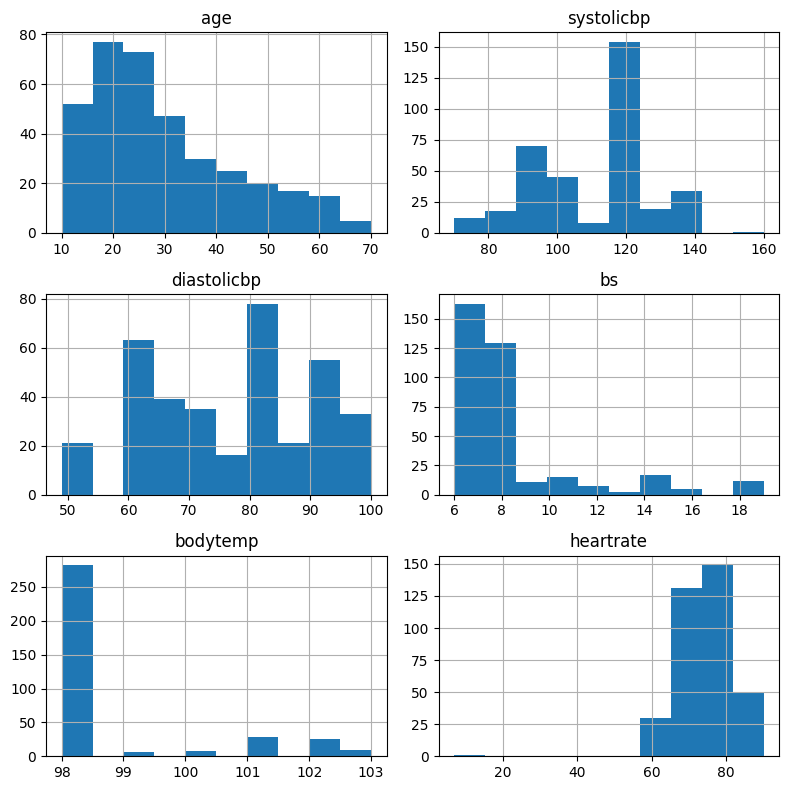

In [9]:
# Analisis univariado
df_train.hist(figsize=(8,8))
plt.tight_layout()
plt.show()

En los graficos, observamos que las variables presentan distribuciones concentradas en algunas barras, y describe lo que dijimos arriba, en bs vemos una la concentracion en los primeros valores y una cola derecha, lo contrario de la variable heartrate, que esta concentrado en los valores a la izquierda y con 'bodytemp' lo que observo es que mas o menos el 80% esta acumulado en el valor 98, lo que podriamos hacer es una variable binaria que nos diga temperatura 'igual a 98' si o no.

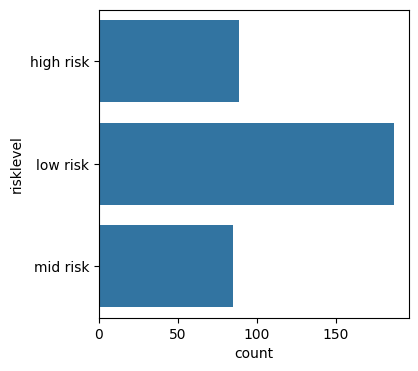

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.countplot(data=df_train, y='risklevel', ax=ax) 
plt.show()

En la variable objetivo se ve que la categoria predominante es 'low risk' como ya vimos en el analisis descriptivo, seguido por 'high risk' y con menos porcentaje 'mid risk'.

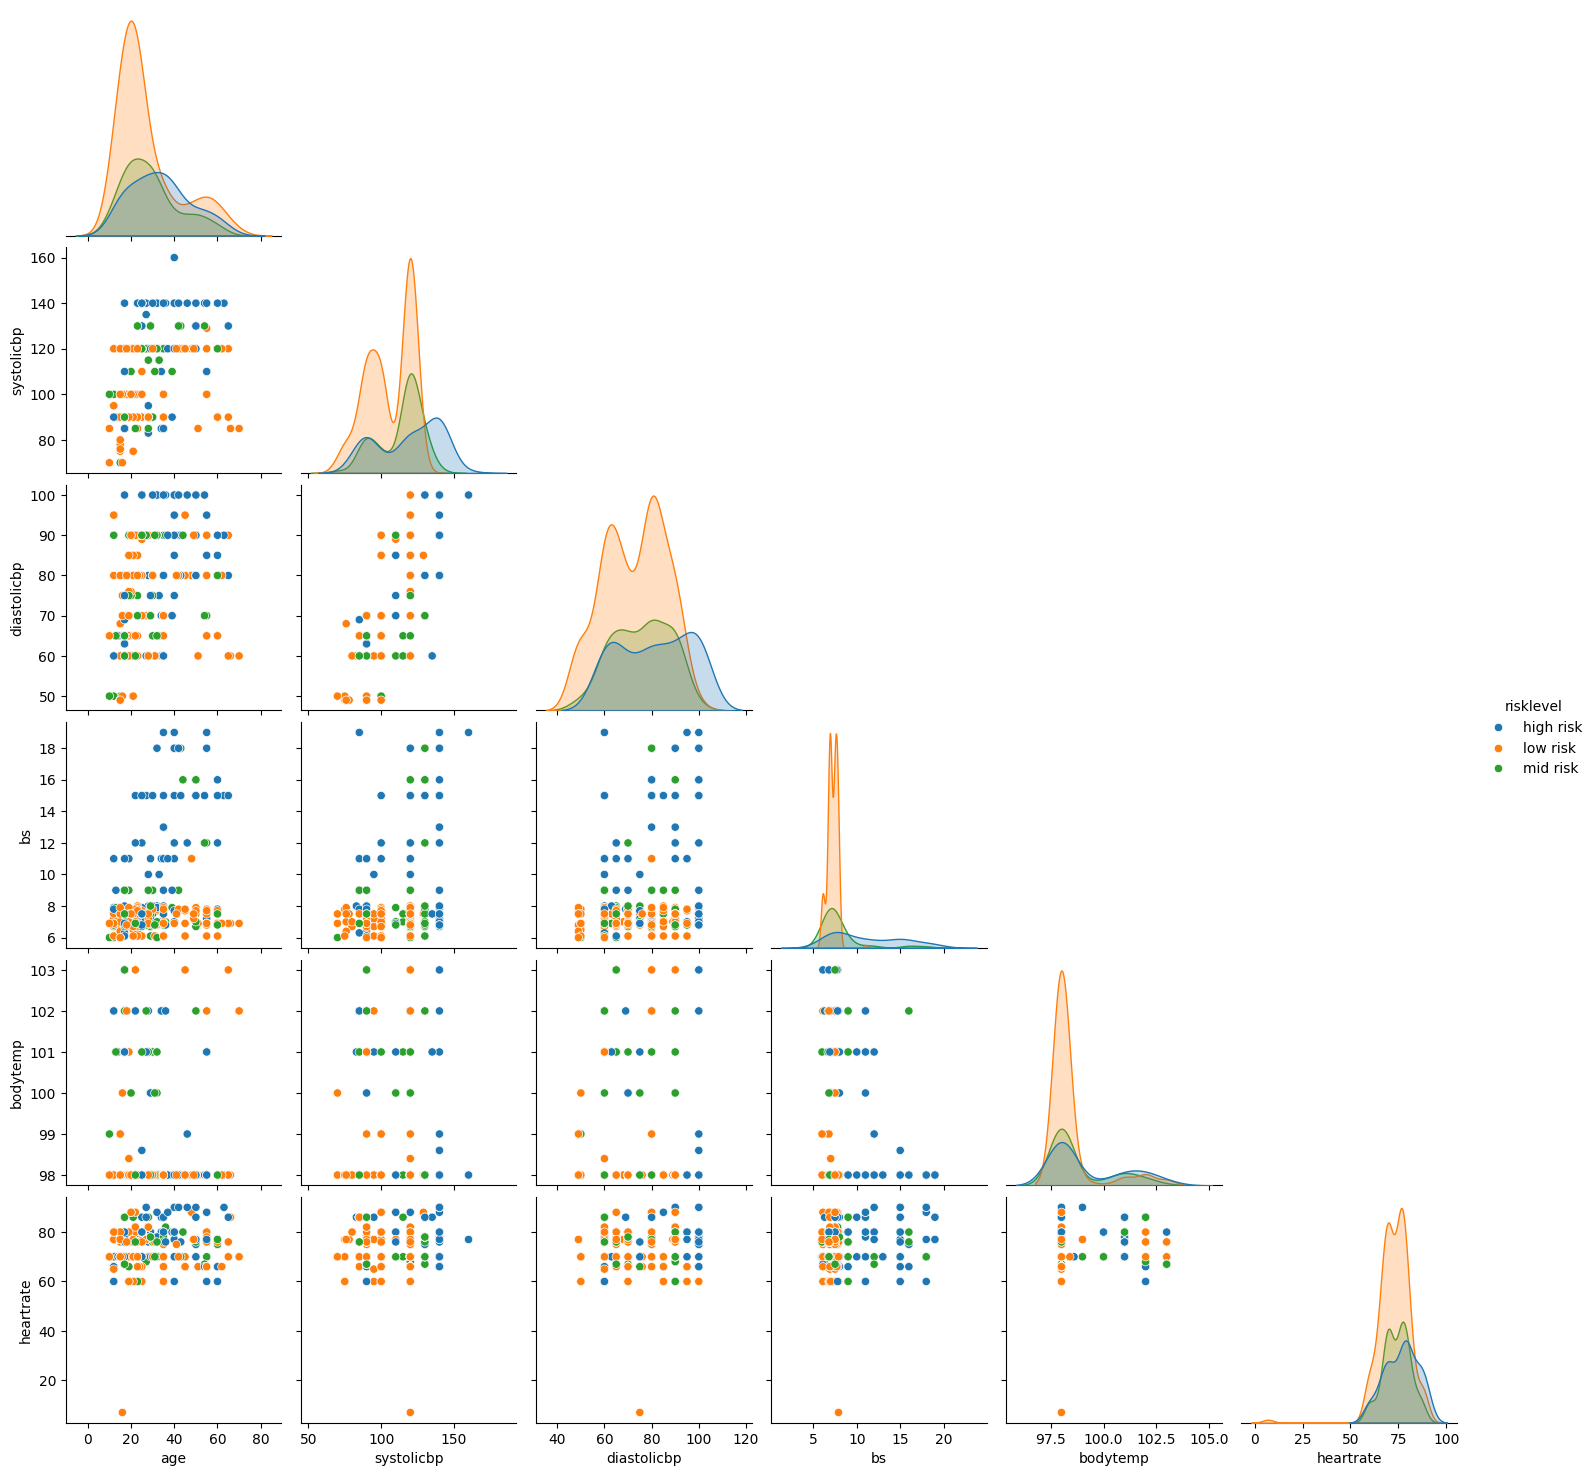

In [11]:
sns.pairplot(data=df_train, hue='risklevel', corner=True)
plt.show()

En el pairplot, en los gráficos de dispersión, no observo ningun patron aparente.
Las variables que separan un poco en los graficos de la diagonal son 'systolicbp', 'diastolicbp', y un poco 'heartrate'

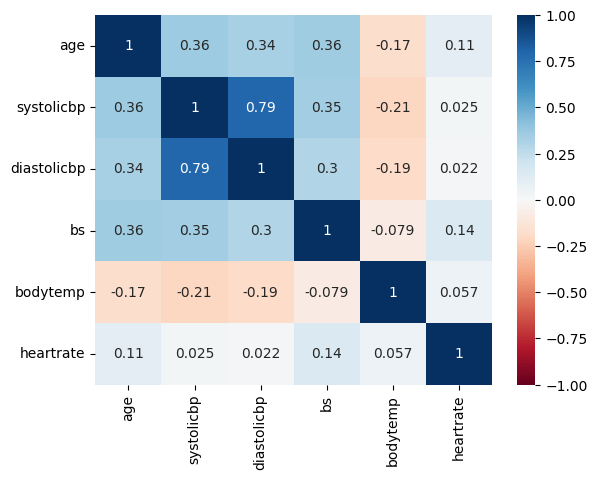

In [12]:
sns.heatmap(data=df_train.select_dtypes('number').corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

En la matriz de correlación, se puede ver en 'systolicbp', 'diastolicbp' una correlación alta, como era de esperarse.

### 4. Machine learning
Objective: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

#### Random forest

In [13]:
X_train = df_train.drop(columns=["risklevel"])
y_train = df_train['risklevel'].copy()
X_test = df_test.drop(columns=["risklevel"])
y_test = df_test['risklevel'].copy()

In [14]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [15]:
clf_rforest_p = Pipeline([
    ("powertransform", PowerTransformer()),
    ("rforest", RandomForestClassifier(random_state=2025)),
])
clf_rforest_cv = GridSearchCV(
    clf_rforest_p,
    param_grid={
        "rforest__max_depth": [3,5,7,9],
        "rforest__n_estimators": [20,30,50,100],
        },
    cv=5,
    n_jobs = -1 # usa todos los trabajadores que puedas
)

In [16]:
clf_rforest_cv.fit(X_train, y_train_enc)
clf_rforest_cv.best_params_

{'rforest__max_depth': 5, 'rforest__n_estimators': 50}

accuracy: 73.63
Matthews Correlation Coefficient: 58.18
              precision    recall  f1-score   support

   high risk       0.95      0.78      0.86        23
    low risk       0.68      0.98      0.80        47
    mid risk       0.75      0.14      0.24        21

    accuracy                           0.74        91
   macro avg       0.79      0.63      0.63        91
weighted avg       0.76      0.74      0.69        91



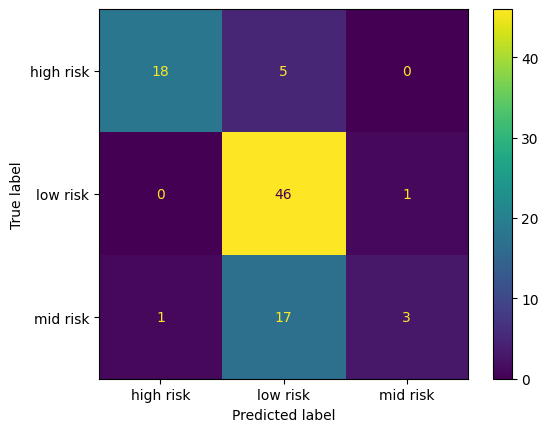

In [17]:
y_hat_test = clf_rforest_cv.predict(X_test)
print(f'accuracy: {accuracy_score(y_test_enc,y_hat_test)*100:.2f}')
print(f'Matthews Correlation Coefficient: {matthews_corrcoef(y_test_enc,y_hat_test)*100:.2f}')
print(classification_report(y_test_enc,y_hat_test,target_names = label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_hat_test, display_labels= label_encoder.classes_)
plt.show()

Con el coeficiente de correlacion de Matthews esta un poco por encima de ser un modelo al azar, el recall es bastante alto cuando es 'low risk', pero extremadamente bajo en 'mid risk'.

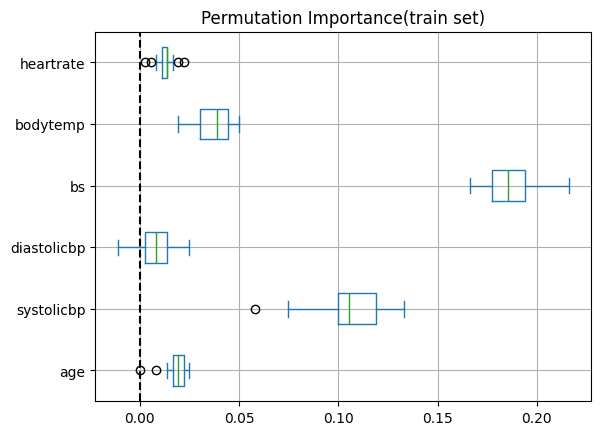

In [18]:
importance = permutation_importance(clf_rforest_cv,X_train,y_train_enc,n_repeats=25,random_state=2025)
importance_df = pd.DataFrame(importance.importances.T,columns=X_train.columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0,color="k",linestyle="--")
ax.set_title("Permutation Importance(train set)")
ax.grid(True)
plt.show()

En el grafico de importancia de las variables, observo que la mejor variable sorprendentemente es 'bs', seguido por 'systolicbp',  'bodytemp', 'age'

#### Decision Tree

In [24]:
clf_tree_p = Pipeline([
    ("tree", DecisionTreeClassifier(random_state=2025)),
])
clf_tree_cv = GridSearchCV(
    clf_tree_p,
    param_grid={
        "tree__max_depth": [3,5,7,9],
        "tree__min_samples_split": [2,4,6,8,10],
        "tree__min_samples_leaf": [1,3,5,7,9],
        "tree__criterion": ["gini","entropy"]
    },
    cv=5,
    n_jobs = -1 # usa todos los trabajadores que puedas
)

In [ ]:
clf_tree_cv.fit(X_train, y_train_enc)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tree',
                                        DecisionTreeClassifier(random_state=2025))]),
             n_jobs=-1,
             param_grid={'tree__criterion': ['gini', 'entropy'],
                         'tree__max_depth': [3, 5, 7, 9],
                         'tree__min_samples_leaf': [1, 3, 5, 7, 9],
                         'tree__min_samples_split': [2, 4, 6, 8, 10]})

In [26]:
clf_tree_cv.best_params_

{'tree__criterion': 'entropy',
 'tree__max_depth': 5,
 'tree__min_samples_leaf': 3,
 'tree__min_samples_split': 2}

accuracy: 74.73
Matthews Correlation Coefficient: 58.53
              precision    recall  f1-score   support

   high risk       0.89      0.74      0.81        23
    low risk       0.71      0.96      0.82        47
    mid risk       0.67      0.29      0.40        21

    accuracy                           0.75        91
   macro avg       0.76      0.66      0.68        91
weighted avg       0.75      0.75      0.72        91



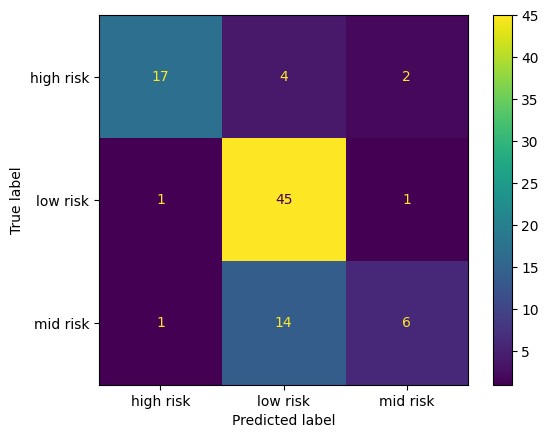

In [27]:
y_hat_test = clf_tree_cv.predict(X_test)
print(f'accuracy: {accuracy_score(y_test_enc,y_hat_test)*100:.2f}')
print(f'Matthews Correlation Coefficient: {matthews_corrcoef(y_test_enc,y_hat_test)*100:.2f}')
print(classification_report(y_test_enc,y_hat_test,target_names = label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_hat_test, display_labels= label_encoder.classes_)
plt.show()

Al ver las metricas de este modelo son muy similares a las del modelo de random forest, sin embargo el coeficiente de correlacion de Mattheus es unas milesimas mas alto.

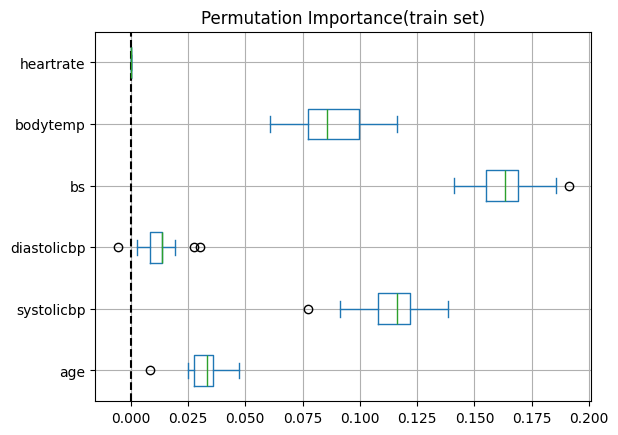

In [29]:
importance = permutation_importance(clf_tree_cv,X_train,y_train_enc,n_repeats=25,random_state=2025)
importance_df = pd.DataFrame(importance.importances.T,columns=X_train.columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0,color="k",linestyle="--")
ax.set_title("Permutation Importance(train set)")
ax.grid(True)
plt.show()

En el grafico de importancia de las variables, observo que la mejor variable sorprendentemente es 'bs', seguido por 'systolicbp', 'bodytemp' ,'age', 'diastolicbp', en este caso 'heartrate' queda en toda la linea del cero, es decir que posiblemente no este aportando al modelo mucho.

#### Gradient Boosting

In [39]:
clf_gb_p = Pipeline([
    ("gb",GradientBoostingClassifier(random_state=2025))
])
clf_gb_cv = GridSearchCV(
    clf_gb_p,
    param_grid={
        "gb__max_depth":[3,5,7,9],
        "gb__n_estimators":[20,30,50,100]
    },
    cv=5,
    n_jobs=-1
)

In [40]:
clf_gb_cv.fit(X_train, y_train_enc)
clf_gb_cv.best_params_

{'gb__max_depth': 3, 'gb__n_estimators': 20}

accuracy: 72.53
Matthews Correlation Coefficient: 55.77
              precision    recall  f1-score   support

   high risk       0.94      0.74      0.83        23
    low risk       0.68      0.98      0.80        47
    mid risk       0.60      0.14      0.23        21

    accuracy                           0.73        91
   macro avg       0.74      0.62      0.62        91
weighted avg       0.73      0.73      0.68        91



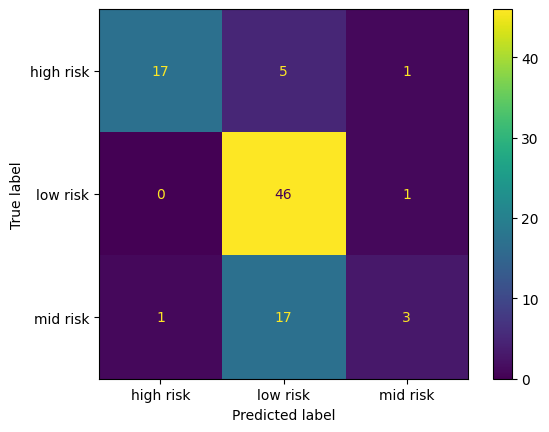

In [41]:
y_hat_test = clf_gb_cv.predict(X_test)
print(f'accuracy: {accuracy_score(y_test_enc,y_hat_test)*100:.2f}')
print(f'Matthews Correlation Coefficient: {matthews_corrcoef(y_test_enc,y_hat_test)*100:.2f}')
print(classification_report(y_test_enc,y_hat_test,target_names = label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_hat_test, display_labels= label_encoder.classes_)
plt.show()

revisando las metricas de los tres algoritmos, puedo decir que este es el que tiene el coeficitente de correlacion de matthews mas bajo.

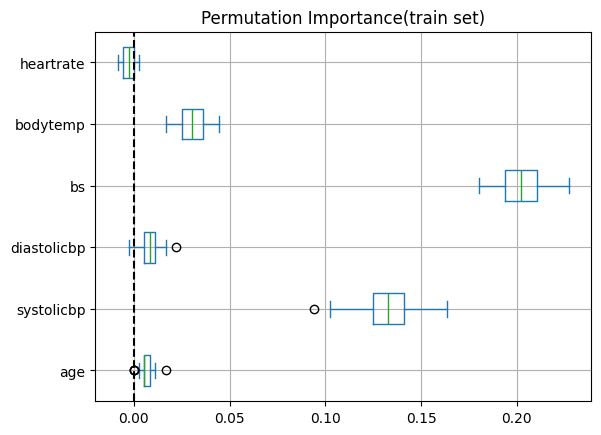

In [43]:
importance = permutation_importance(clf_gb_cv,X_train,y_train_enc,n_repeats=25,random_state=2025)
importance_df = pd.DataFrame(importance.importances.T,columns=X_train.columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0,color="k",linestyle="--")
ax.set_title("Permutation Importance(train set)")
ax.grid(True)
plt.show()

En el grafico de importancia de las variables, observo que la mejor variable sorprendentemente es 'bs', seguido por 'systolicbp', 'bodytemp' , 'diastolicbp', y 'age', en este caso 'heartrate' queda detras de la linea del cero, es decir que posiblemente no este aportando al modelo